<a href="https://colab.research.google.com/github/tranduy199984/RB-Revenue-Forecast-Model-Holt-Winter-s/blob/main/Sales_Data_Forecast__Holt_Winter's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Important: 
1. Always load the data file in .CSV, otherwise it won't work :)
2. Check the accurate file pathway
3. Update the right 'Period' & 'Difference' for each market

# 1. (Ugly stuff) Loading libraries


In [ ]:
# dataframe opertations - pandas
import pandas as pd
import numpy as np
# plotting data - matplotlib
from matplotlib import pyplot as plt
# time series - statsmodels 
# Seasonality decomposition
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Review the accuracy
from sklearn.metrics import mean_absolute_error,mean_squared_error

# 2. Loading data (Check pathways)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
forecast_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Robust Ventures/Raw_data.csv',index_col='Date', parse_dates=True)

(27, 1)
            Revenue
Date               
2022-01-31     1483
2022-02-07     1951
2022-02-14     1324
2022-02-21      567
2022-02-28      629


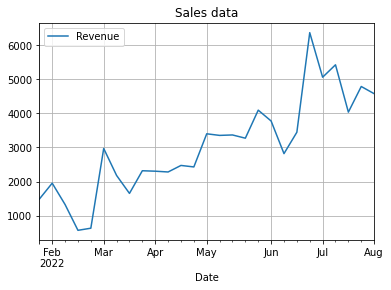

In [ ]:
Raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Robust Ventures/Raw_data.csv',index_col='Date', parse_dates=True)


# finding shape of the dataframe
print(Raw_data.shape)
# having a look at the data
print(Raw_data.head())
# plotting the original data
Raw_data[['Revenue']].plot(title='Sales data')
plt.grid(True)

In [ ]:
#Checking if there is any missing values

Raw_data.isnull().sum()

Revenue    0
dtype: int64

# 3: Updating period

In [ ]:
# Set the value of Alpha and define m (Time Period)
m = 2
alpha = 1/(2*m)

# 4. (Ugly stuff) Decomposing the Time Series

In [ ]:
# Reconstruct the dataset (Date as the assigned independent variable)

Raw_data = Raw_data.resample(rule='W').sum()

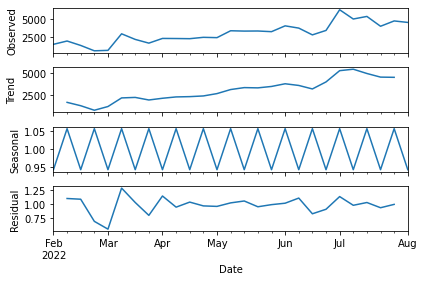

In [ ]:
Raw_data = Raw_data.groupby('Date').sum()

decompose_result = seasonal_decompose(Raw_data,model='multiplicative', freq = m)
decompose_result.plot();

# 5. (Ugly stuff) Train test Split

In [ ]:
count = len(Raw_data) - 6
train = Raw_data[:count] #til the most recent week
test = Raw_data[count:] # from the most recent week
train.tail()

,Revenue
Date,
2022-05-29,3272
2022-06-05,4095
2022-06-12,3777
2022-06-19,2819
2022-06-26,3447


In [ ]:
test

,Revenue
Date,
2022-07-03,6371
2022-07-10,5062
2022-07-17,5427
2022-07-24,4037
2022-07-31,4790
2022-08-07,4579


# 6. (Kinda Ugly Stuff) Holt-Winter's Model

In [ ]:
# Set the frequency of the date time index as Weekly start as indicated by the data
Raw_data.index.freq = 'W'

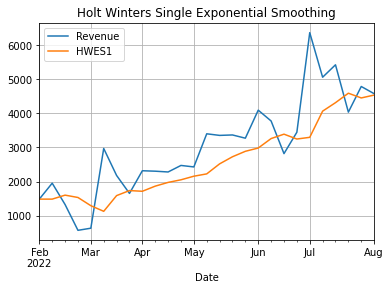

In [ ]:
# Single HWES (H-w Exponential Smoothing)
Raw_data['HWES1'] = SimpleExpSmoothing(Raw_data['Revenue']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
Raw_data[['Revenue','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');
plt.grid(True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


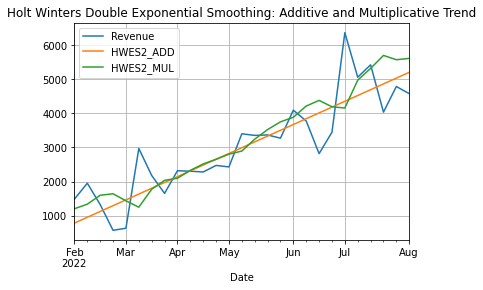

In [ ]:
# Double HWES (H-w Exponential Smoothing)
Raw_data['HWES2_ADD'] = ExponentialSmoothing(Raw_data['Revenue'],trend='add').fit().fittedvalues
Raw_data['HWES2_MUL'] = ExponentialSmoothing(Raw_data['Revenue'],trend='mul').fit().fittedvalues
Raw_data[['Revenue','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');
plt.grid(True)

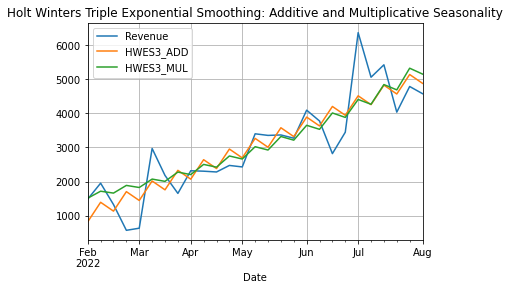

In [ ]:
# Tripple HWES (H-w Exponential Smoothing)
Raw_data['HWES3_ADD'] = ExponentialSmoothing(Raw_data['Revenue'],trend='add',seasonal='add',seasonal_periods=m).fit().fittedvalues
Raw_data['HWES3_MUL'] = ExponentialSmoothing(Raw_data['Revenue'],trend='mul',seasonal='mul',seasonal_periods=m).fit().fittedvalues
Raw_data[['Revenue','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');
plt.grid(True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


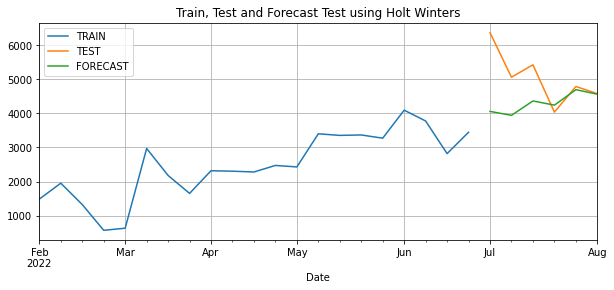

In [ ]:
fitted_model = ExponentialSmoothing(train['Revenue'],trend='mul',seasonal='mul',seasonal_periods=m).fit()
test_predictions = fitted_model.forecast(6)
train['Revenue'].plot(legend=True,label='TRAIN')
test['Revenue'].plot(legend=True,label='TEST',figsize=(10,4))
test_predictions.plot(legend=True,label='FORECAST')
plt.title('Train, Test and Forecast Test using Holt Winters');
plt.grid(True)

In [ ]:
test_predictions

2022-07-03    4058.129020
2022-07-10    3943.271554
2022-07-17    4365.675283
2022-07-24    4242.113317
2022-07-31    4696.529012
2022-08-07    4563.602873
Freq: W-SUN, dtype: float64

# 7. (Ugly stuff) Review and Evaluation Metrics

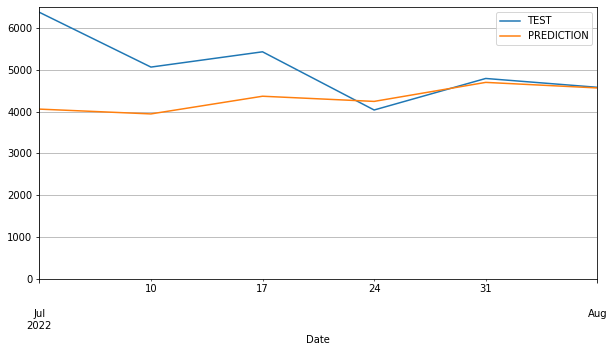

In [ ]:
test['Revenue'].plot(legend=True,label='TEST',figsize=(10,5))
test_predictions.plot(legend=True,label='PREDICTION');
plt.ylim(bottom=0)
plt.grid(True)


In [ ]:
print(f'Mean Absolute Error = {mean_absolute_error(test,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test,test_predictions)}')

Mean Absolute Error = 801.1509291738984
Mean Squared Error = 1296396.8387171684


In [ ]:
np.sqrt(mean_squared_error(test,test_predictions))

1138.594237960639

In [ ]:
Raw_data.Revenue.mean(),np.sqrt(Raw_data.Revenue.var())

(3050.0, 1428.6539119044892)

In [ ]:
test_array = test.to_numpy()
test_predictions_array = test_predictions.to_numpy()
test_array_row = test_array.transpose()
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
mape(test_array_row[0,:], test_predictions_array)

14.221412922743855

# 8. Final Forecast Model

In [ ]:
# Here shows the forecast data of the upcoming 6 weeks

final_model = ExponentialSmoothing(Raw_data.Revenue, trend='add',seasonal='mul',seasonal_periods=m).fit()
pred = final_model.forecast(6)
pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2022-08-14    5620.096156
2022-08-21    5061.361613
2022-08-28    5871.399522
2022-09-04    5282.731789
2022-09-11    6122.702889
2022-09-18    5504.101965
Freq: W-SUN, dtype: float64

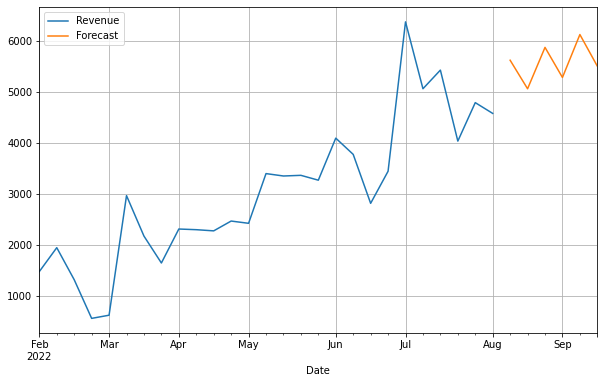

In [ ]:
# And the plot of forecast data along with the whole dataset

Raw_data['Revenue'].plot(legend=True,label='Revenue',figsize=(10,6))
pred.plot(legend=True, label = 'Forecast')
plt.grid(True)

In [ ]:
# mean absolute percentage error
print(f'Percentage of Mean absolute percentage error is MAPE = {mape(test_array_row[0,:], test_predictions_array)}%')

Percentage of Mean absolute percentage error is MAPE = 14.221412922743855%
